In [1]:
import pandas as pd
import numpy as np
from OLS import OLS
from StandardScaler import StandardScaler
from stat_tests import AR1, ADF

import matplotlib.pyplot as plt

In [2]:
s = StandardScaler()
df = pd.read_csv("data/housing.csv", low_memory=False, encoding="utf-8")
yn_map = {"yes": 1, "no": 0}

In [3]:
y = df.price.values
X = df.drop(columns=["price"])

# Map binaries to 0/1
X.mainroad = X.mainroad.map(yn_map)
X.guestroom = X.guestroom.map(yn_map)
X.basement = X.basement.map(yn_map)
X.hotwaterheating = X.hotwaterheating.map(yn_map)
X.airconditioning = X.airconditioning.map(yn_map)
X.prefarea = X.prefarea.map(yn_map)

# Get One-Hot for categoricals
furnish_dummies = pd.get_dummies(X.furnishingstatus, drop_first=True).astype(int)
X = X.drop(columns=["furnishingstatus"])
X = pd.concat([X, furnish_dummies], axis=1)

# Remove colnames for symbolic brevity
X = s.fit_transform(X.values)
X

array([[ 1.04672629,  1.40341936,  1.42181174, ...,  1.80494113,
        -0.84488844, -0.6964292 ],
       [ 1.75700953,  1.40341936,  5.40580863, ..., -0.55403469,
        -0.84488844, -0.6964292 ],
       [ 2.21823241,  0.04727831,  1.42181174, ...,  1.80494113,
         1.18358821, -0.6964292 ],
       ...,
       [-0.70592066, -1.30886273, -0.57018671, ..., -0.55403469,
        -0.84488844,  1.43589615],
       [-1.03338891,  0.04727831, -0.57018671, ..., -0.55403469,
        -0.84488844, -0.6964292 ],
       [-0.5998394 ,  0.04727831, -0.57018671, ..., -0.55403469,
        -0.84488844,  1.43589615]], shape=(545, 13))

In [4]:
X_test = X[-1]
y_yest = y[-1]

X_fit = X[:-1, :]
y_fit = y[:-1]

ols = OLS(X_fit, y_fit)
fit = ols.fit()

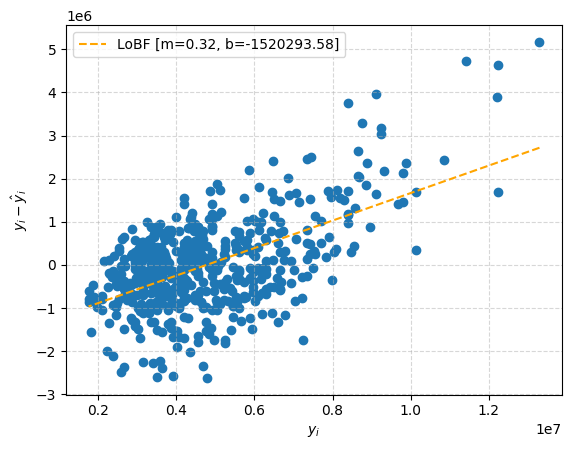

In [5]:
n = len(fit.resid)
m, b = np.polyfit(y_fit, fit.resid, 1)

line = m * y_fit + b


plt.scatter(y_fit, fit.resid)
plt.plot(y_fit, line, label=f"LoBF [{m=:.2f}, {b=:.2f}]", linestyle="--", color="orange")

plt.xlabel(r"$y_i$")
plt.ylabel(r"$y_i - \hat{y}_i$")

plt.grid(alpha=0.5, linestyle="--")

plt.legend()
plt.show()

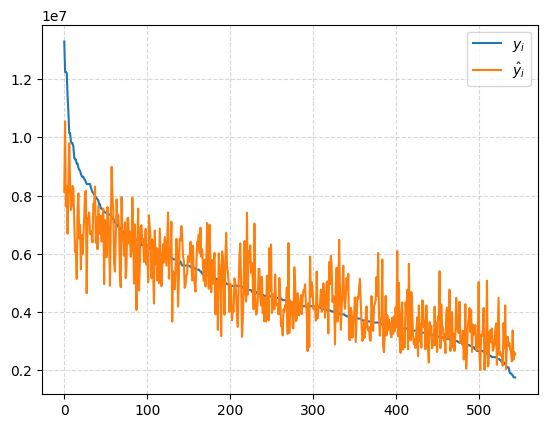

In [6]:
x = np.array([i for i in range(len(y_fit))])
plt.plot(x, y_fit, label=r"$y_i$")
plt.plot(x, fit.fitted_values, label=r"$\hat{y}_i$")

plt.grid(alpha=0.5, linestyle="--")
plt.legend()
plt.show()

In [7]:
fit.error

R2: 0.6814
R2_ADJ: 0.673
RMSE: 1053178.4252
MAPE: 0.1708

In [8]:
ols.predict(X_test)

np.float64(3240565.3246454997)

In [9]:
ADF(fit.resid)

1.518481580299785e-08


AttributeError: 'NoneType' object has no attribute 'reject'